In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python3 --version

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 10.2.0
-- The CXX compiler identification is GNU 10.2.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/nicolas/Development/College/mn-2020-2c/tp2/env/bin/python3 (found version "3.7.7") 
-- Found PythonLibs: /home/nicolas/.pyenv/versions/3.7.7/lib/libpython3.7m.a
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/nicolas/Development/College/mn-2020-2c/tp2
-- Configuring done
-- Generating done
-- Build files have been writte

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import metnum as mt
import os
import seaborn as sns
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold
from tqdm import tqdm

#percentage over total of train cases
PERCENTAGE_OF_TRAIN_CASES = 1
#neighbors for finding the mode in KNN
N_NEIGHBORS = 1
#components for PCA
N_COMPONENTS=40
#number of iterations to find eigenvalues and eigenvectors in power iteration
N_ITERATIONS=5000
#epsilon for power iteration
EPSILON=1e-10

In [3]:
#directory for saving matrix files
timestamp = datetime.now().strftime("%m_%d_%H_%M_%S")
DIRECTORY_NAME="{}".format(timestamp)
os.makedirs(DIRECTORY_NAME+"/", exist_ok=True)

%load_ext autoreload
%autoreload 2

df_train = pd.read_csv("../data/train.csv")

TOTAL_TRAIN_CASES = int(PERCENTAGE_OF_TRAIN_CASES*len(df_train))

#shuffle the train cases.
df_train = df_train[0: TOTAL_TRAIN_CASES].sample(frac=1)

# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)
print(f"Instancias de entrenamiento: {len(X_train)}")
print(f"Instancias de validación: {len(X_val)}")

Instancias de entrenamiento: 33600
Instancias de validación: 8400


In [ ]:
#Individual Tests

clf = mt.KNNClassifier(N_NEIGHBORS)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
cohen = cohen_kappa_score(y_val, y_pred)

print(acc)
print(cohen)



## Experimentación 3-Fold cross-validation 

100%|██████████| 16/16 [11:48:15<00:00, 2655.98s/it]


CPU times: user 11h 44min 14s, sys: 3min 40s, total: 11h 47min 55s
Wall time: 11h 48min 15s


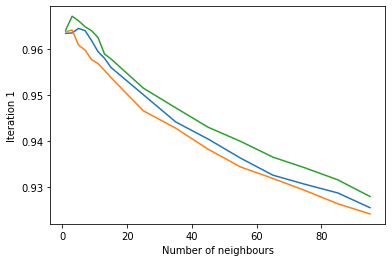

In [4]:
%%time
#3-Fold Cross validation
k = 3

amount = X.shape[0] // k

list_acc = []
neighbour_values = [1,3,5,7,9,11,13,15,25,35,45,55,65,75,85,95]
three_fold_df = {
    'Number of neighbours': neighbour_values
}

accuracy_1 = []
accuracy_2 = []
accuracy_3 = []

for neighbours in tqdm(neighbour_values):
    for i in tqdm(range(3)):
    
        X_train = np.concatenate((X[0:amount*i], X[amount * (i+1):]))
        y_train = np.concatenate((y[0:amount*i], y[amount * (i+1):]))
        X_val = X[amount*i:amount*(i+1)]
        y_val = y[amount*i:amount*(i+1)]
    
        clf = mt.KNNClassifier(neighbours)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        
        acc = accuracy_score(y_val, y_pred)
        
        if(i == 0):
            accuracy_1.append(acc)
        elif(i == 1):
            accuracy_2.append(acc)
        else:
            accuracy_3.append(acc)
            
three_fold_df.setdefault('Iteration 1',accuracy_1)
three_fold_df.setdefault('Iteration 2',accuracy_2)
three_fold_df.setdefault('Iteration 3',accuracy_3)

dfff = pd.DataFrame(three_fold_df)
dfff.to_csv("3_fold")

sns.lineplot(data = dfff, x = 'Number of neighbours', y = "Iteration 1")
sns.lineplot(data = dfff, x = 'Number of neighbours', y = "Iteration 2")
sns.lineplot(data = dfff, x = 'Number of neighbours', y = "Iteration 3")

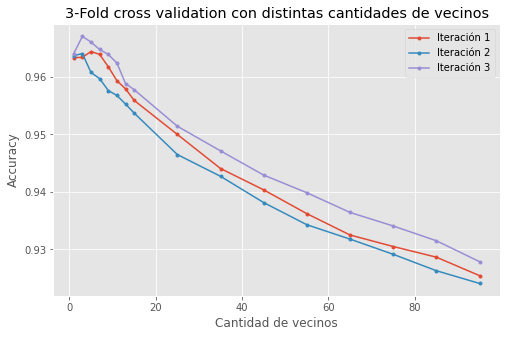

In [5]:
# CSV generado en celda anterior
dfff = pd.read_csv('3_fold')

neibs = dfff['Number of neighbours'].to_list()

it1 = dfff['Iteration 1'].to_list()
it2 =  dfff['Iteration 2'].to_list()
it3 =  dfff['Iteration 3'].to_list()

plt.figure(figsize=(8,5))
plt.style.use('ggplot')
plt.plot(neibs, it1, marker = '.')
plt.plot(neibs, it2, marker = '.')
plt.plot(neibs, it3, marker = '.')
plt.xlabel('Cantidad de vecinos')
plt.ylabel('Accuracy')
plt.title('3-Fold cross validation con distintas cantidades de vecinos')
plt.legend(['Iteración 1', 'Iteración 2', 'Iteración 3'])
plt.savefig("3_fold_cross_validation_cant_vecinos.png")

In [65]:
sum = 0

for x in range (16):
    sum = sum + abs(it1[x]-it2[x])
    
sum = sum / 16   

print(sum)

suma = 0

for x in range (16):
    suma = suma + abs(it1[x]-it3[x])**2
    
suma = suma / 16 

print(suma)

sumb = 0

for x in range (16):
    sumb = sumb + abs(it3[x]-it2[x])**2
    
sumb = sumb / 16 

print(sumb)




0.003040178571428548
1.8577806122448923e-06
1.3788584183673533e-05
